#


# Ornstein-Uhlenbeck process simulation - GPU-vectorized version

$$dX_t = \theta \, (\mu -X_t)\, dt + \sigma \, dW_t$$

$X_{t + dt} \mid X_t = x$ is Gaussian so there is an algebraic solution :

$$X_{t + dt} = \mu + (X_t - \mu) \, e^{-\theta \,dt} + \sqrt{(\sigma^2/2\theta)(1 - e^{-2\theta dt})} \,\, Z \;\;\;, \; Z \sim \mathcal{N}(0, 1)$$

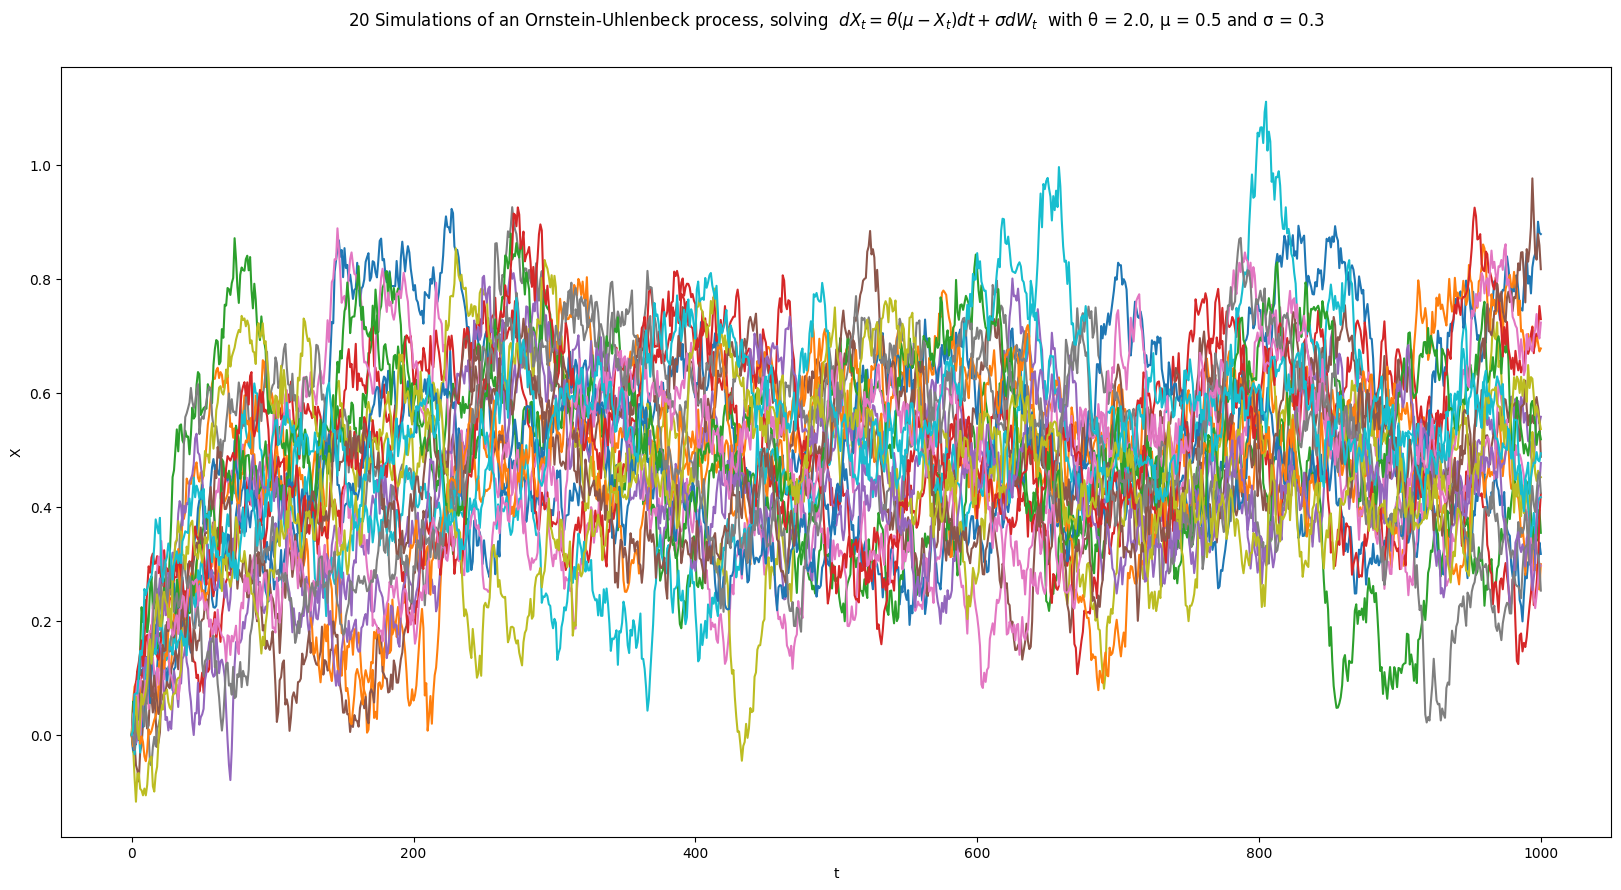

In [16]:
%matplotlib inline


import torch
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

import seaborn.objects as so

def ou_process (theta: float,
                mu: float,
                sigma: float,
                x0: float,
                dt: float,
                num_steps: int,
                num_paths: int,
                device: torch.device
) -> torch.Tensor:

  theta = torch.as_tensor(theta, device=device)
  mu = torch.as_tensor(mu, device=device)
  sigma = torch.as_tensor(sigma, device=device)
  x0 = torch.as_tensor(x0, device=device)
  num_steps = torch.as_tensor(num_steps, device=device)
  num_paths = torch.as_tensor(num_paths, device=device)

  kernel = torch.exp(-theta * dt)
  variance = (sigma ** 2)/(2 * theta) * (1 - kernel ** 2)
  stddev = torch.sqrt(variance)

  # Generate Gaussian noise on GPU
  noise = torch.randn(num_steps, num_paths, device=device) * stddev

  xs = torch.empty((num_steps + 1, num_paths), device=device)
  if torch.is_tensor(x0):
    xs[0] = x0
  else:
    xs[0] = torch.full((num_paths,), x0, device)

  for i in range(num_steps):
    xs[i+1] = mu + (xs[i]- mu)*kernel + noise[i]

  # TODO: measure torch.cumsum, torch.func.scan version

  return xs




if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

num_paths = 20
num_steps = 1000
dt = 0.01

theta = 2.0
mu = 0.5
sigma = 0.3
x0 = 0.0

x = ou_process(theta, mu, sigma, x0, dt, num_steps, num_paths, device)
X = x.cpu().numpy()

#print(x.shape, x.device)
#print(x[-1, :5])

#x.columns=np.arange(0.8,2,0.2)
plt.plot(X)
#plt.legend(x.columns)
plt.xlabel('t')
plt.ylabel('X')
theta_utf = "\u03B8"
mu_utf = "\u03BC"
sigma_utf = "\u03C3"
sub_t = "\u209C"
title = f"{num_paths} Simulations of an Ornstein-Uhlenbeck process, solving  " + \
        f"$dX_t = {theta_utf} ({mu_utf} - X_t) dt + {sigma_utf} dW_t$  with " + \
        f"{theta_utf} = {theta}, {mu_utf} = {mu} and {sigma_utf} = {sigma}"
plt.title(title, pad=30)
plt.show()